<a href="https://colab.research.google.com/github/Sahanave/CodePapers/blob/main/PodcastGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Your Own Podcast Host

What are we building : An intelligent podcast host built on the ReAct framework that dynamically creates engaging podcast content

What do we need : OpenAI API key, Tavily Key, ElevenLabs API key

What Framework do we use : LangGraph

In [4]:
from google.colab import userdata

In [5]:
import re
import os
import json
import requests
from IPython.display import display, Audio, HTML
from google.colab import output
from datetime import datetime
import tempfile

Build Our version 1: LLM + Search Tool + Voice Tool

In [11]:
# Install required packages
!pip install -q langchain_community langchain_core langgraph typing_extensions
!pip install -q langchain_openai tavily-python elevenlabs

In [32]:
import os
from typing import Dict, List, Optional
from langgraph.graph import StateGraph
from typing import TypedDict
from langgraph.graph import START, END
from langchain.chat_models import init_chat_model
from langchain_community.tools import TavilySearchResults
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from elevenlabs.client import ElevenLabs
from elevenlabs import play


class WebSearchState(TypedDict):
    query: str
    search_results: list[dict]
    processed_results: str
    voice_response : bool

In [37]:
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')
class Agent():
    "Skeleton to test our implementation"
    def __init__(self):
        self.llm = None
        self.search_tool = None
        self.graph = None
        self.model_name = "gpt-4o-mini"
        self.model_provider = "openai"
        self.llm_prompt = None

    def initialize(self) -> None:
        """Initialize components for web search.

        - Initialize the LLM
        - Set up Tavily search tool
        - Create a LangGraph for web search workflow
        """
        self.llm = init_chat_model(self.model_name, model_provider=self.model_provider)

        self.search_tool = TavilySearchResults(
                                max_results=5,
                                include_answer=True,
                                include_raw_content=True,
                                include_images=False,
                                search_depth="advanced")


        graph_builder = StateGraph(WebSearchState)
        graph_builder.add_node("search_web", self._create_search_node)
        graph_builder.add_node("process_results", self._create_process_results_node)
        graph_builder.add_node('voice_node', self._call_voice_tool)

        graph_builder.add_edge(START, "search_web")
        graph_builder.add_edge("search_web", "process_results")
        graph_builder.add_edge("process_results", "voice_node")
        graph_builder.add_edge("voice_node", END)

        self.graph = graph_builder.compile()

    def _create_search_node(self, state: WebSearchState):
        """Create a node that performs web search."""
        results = self.search_tool.invoke({"query": state["query"]})
        return {"search_results": results }

    def _call_voice_tool(self, state:WebSearchState):
        """Create a node that performs web search."""
        question = state["processed_results"]
        client = ElevenLabs(
        api_key=userdata.get('ELEVENLABS_API_KEY'))
        audio = client.text_to_speech.convert(
                text=question,
                voice_id="JBFqnCBsd6RMkjVDRZzb",
                model_id="eleven_multilingual_v2",
                output_format="mp3_44100_128",
            )
        play(audio)
        return {"voice_response": True }



    def _create_process_results_node(self, state:WebSearchState):
        """Create a node that processes and formats search results."""
        prompt = "You are a Podcast Host. You are given a question and relevant search results. Use the search results and query provided"
        if self.llm_prompt:
          prompt += self.llm_prompt

        user_query = f'''User : {state["query"]}, relevant_web_search_information : {state["search_results"]}'''
        prompt_template = ChatPromptTemplate.from_messages(
        [("system", prompt), ("user", "{user_input}")])
        prompt = prompt_template.invoke({"user_input": user_query})
        prompt_messages = prompt.to_messages()
        response = self.llm.invoke(prompt_messages)
        return {"processed_results": response.content }


    def podcast_topic(self, podcast_topic: str) -> str:
        """Creates a podcast from topic

        Args:
            message: The user's input message
            chat_history: Previous conversation history

        Returns:
            str: The assistant's response with search results
        """

        result = self.graph.invoke({"query": podcast_topic})
        print(result)
        message = result["processed_results"]

        # This is just a placeholder
        return f"PodCast_convo: {message}"

In [38]:
version1 = Agent()
version1.llm_prompt = "Prepare me a podcast with 3 (Steps) 2 (Types) 1 (Thing) framework. Keep the conversation under 2 minutes"
version1.initialize()

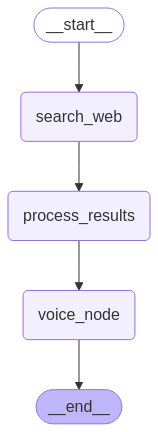

In [39]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        version1.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [40]:
version1.podcast_topic("gemini")

{'query': 'gemini', 'search_results': "HTTPError('401 Client Error: Unauthorized for url: https://api.tavily.com/search')", 'processed_results': "**Podcast Title: Understanding the Gemini Zodiac Sign**\n\n**Host: Welcome to today's episode! Let’s dive into the captivating world of astrology and focus specifically on the Gemini Zodiac sign.**\n\n---\n\n**Step 1: Know the Traits of Gemini**\nGeminis are known for their duality – they represent two sides, symbolized by the Twins. Typically, they are adaptable, intelligent, and social beings. Their versatility keeps them upbeat and helps them connect with various people. However, their dual nature also means they can be indecisive and sometimes inconsistent.\n\n**Step 2: Embrace Communication**\nOne strong trait of Gemini is their communication skills. They thrive in social interactions and are often seen as excellent conversationalists. If you find yourself in a conversation with a Gemini, be prepared for a lively exchange!\n\n**Step 3: F

"PodCast_convo: **Podcast Title: Understanding the Gemini Zodiac Sign**\n\n**Host: Welcome to today's episode! Let’s dive into the captivating world of astrology and focus specifically on the Gemini Zodiac sign.**\n\n---\n\n**Step 1: Know the Traits of Gemini**\nGeminis are known for their duality – they represent two sides, symbolized by the Twins. Typically, they are adaptable, intelligent, and social beings. Their versatility keeps them upbeat and helps them connect with various people. However, their dual nature also means they can be indecisive and sometimes inconsistent.\n\n**Step 2: Embrace Communication**\nOne strong trait of Gemini is their communication skills. They thrive in social interactions and are often seen as excellent conversationalists. If you find yourself in a conversation with a Gemini, be prepared for a lively exchange!\n\n**Step 3: Foster Flexibility**\nFlexibility is key when dealing with a Gemini. They appreciate spontaneity and variety, so be open to new exp